# Importing Data

In [2]:
# Install using "pip install surprise"
import numpy as np
import numba
import matplotlib.pyplot as plt

In [3]:
# Matrix factorization functions from homework
@numba.jit
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    # Gradient with respect to Ui
    return eta*(reg*Ui-Vj*(Yij-np.dot(Ui.T,Vj)))

@numba.jit
def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # Gradient with respect to Vj
    return eta*(reg*Vj-Ui*(Yij-np.dot(Vj.T,Ui)))

@numba.jit
def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = 0
    # Compute squared error
    for i,j,Yij in Y:
        i=i-1
        j=j-1
        err = err + (Yij-np.dot(U[i],V[j]))**2
    # Return MSE + regularization
    return err/len(Y)/2+reg/2.0*(np.linalg.norm(U)**2+np.linalg.norm(V)**2)

@numba.jit
def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # initial U and V to random floats from -0.5 to 0.5
    U = np.reshape(np.random.rand(M*K)-0.5,(M,K))
    V = np.reshape(np.random.rand(N*K)-0.5,(N,K))
    # Storage of U,V,err for each epoch
    data = []
    # For eps termination
    preverr = 100
    for epoch in range(0,max_epochs):
        # Shuffles the data before each epoch
        idx=np.random.permutation(np.arange(len(Y)))
        for i,j,Yij in Y[idx]:
            # Convert indices counting from 0
            i=i-1
            j=j-1
            Ui = U[i]
            Vj = V[j]
            # Randomly update U or V
            if np.random.randint(2):                
                U[i]=U[i]-grad_U(Ui, Yij, Vj, reg, eta)
            else:
                V[j]=V[j]-grad_V(Vj, Yij, Ui, reg, eta)
        # Compute the error
        err = get_err(U,V,Y)
        data.append([U,V,err])
        if epoch%5==0:
            print('SGD on epoch ',epoch,', error=',err)
        # Terminate if error reduction is less than eps
        if abs(err-preverr) < eps:
            print('EPS condition reached')
            break
        preverr = err
    # Final output
    data=np.array(data)
    return data[-1,0],data[-1,1],data[-1,2]

In [3]:
# Reader that reads tab-separated data
full = np.loadtxt("./data/data.txt")

# Hyperparameter optimization

Optimize $\lambda$ while fixing $\kappa=20$

In [4]:
%%time
# Plotting code implementations for problem 2E
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
K = 20

regs = np.linspace(0,0.5,11)
eta = 0.03 # learning rate

E_train = []
E_val = []
# Use to compute Ein and Eout
for reg in regs:
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U,V, e_in = train_model(M, N, K, eta, reg, Y_train)
    E_train.append(e_in)
    eout = get_err(U, V, Y_test)
    E_val.append(eout)

E_train = np.array(E_train)
E_val = np.array(E_val)

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0
SGD on epoch  0 , error= 0.832277249219461
SGD on epoch  5 , error= 0.34519162287889454
SGD on epoch  10 , error= 0.27928504367079743
SGD on epoch  15 , error= 0.24621755995438693
SGD on epoch  20 , error= 0.22667029265907315
SGD on epoch  25 , error= 0.21395371972606256
SGD on epoch  30 , error= 0.20379147883353282
SGD on epoch  35 , error= 0.19862087408193924
SGD on epoch  40 , error= 0.1904973491224781
SGD on epoch  45 , error= 0.18940611198003066
SGD on epoch  50 , error= 0.18498875558589098
EPS condition reached
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.05
SGD on epoch  0 , error= 0.8394884036329793
SGD on epoch  5 , error= 0.3744282782854446
SGD on epoch  10 , error= 0.31995002677856066
SGD on epoch  15 , error= 0.28393003912584336
SGD on epoch  20 , error= 0.2631186877653127
SGD on epoch  25 , error= 0.24973303119861137
SGD on epoch  30 , error= 0.24087041793321537
SGD on epoch  35 , er

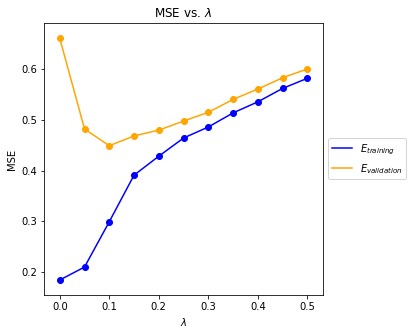

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


In [13]:
# Plot values of E_in across k for each value of lambda
plt.figure(1,figsize=(5,5))
plt.plot(regs, E_train, label='$E_{training}$',color='blue')
plt.scatter(regs, E_train,color='blue')
plt.plot(regs, E_val, label='$E_{validation}$',color='orange')
plt.scatter(regs, E_val,color='orange')
plt.title('MSE vs. $\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MatrixFactor_hw.png',bbox_inches='tight')
plt.show()
print(regs)

# Training on Full Dataset, Getting Matrices

In [14]:
%%time
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K=20
reg = 0.1
eta = 0.03 # learning rate
U,V,err = train_model(M, N, K, eta, reg, Y_train)

Factorizing with  943  users,  1682  movies.
SGD on epoch  0 , error= 0.838759088899908
SGD on epoch  5 , error= 0.4040209334534994
SGD on epoch  10 , error= 0.37139955597416313
SGD on epoch  15 , error= 0.34825643677953094
SGD on epoch  20 , error= 0.3287539148730221
SGD on epoch  25 , error= 0.31732036208662645
SGD on epoch  30 , error= 0.30608650890350625
SGD on epoch  35 , error= 0.29879871520665846
SGD on epoch  40 , error= 0.2954718047185768
EPS condition reached
CPU times: user 58.6 s, sys: 3.39 s, total: 1min 1s
Wall time: 59.1 s


# SVD and Projection

In [15]:
# Do SVD (singular value decomposition) on the matrices
A, Sigma, B = np.linalg.svd(V, full_matrices=False) # V = A @ np.diag(Sigma) @ B
# Get PCA representation of movie vector V
V_PCA = np.dot(A[:2],V.T).T

print('Sigma of PCA')
print(Sigma)
print('Variability captured by top 2 components = ',(Sigma[0]+Sigma[1])/np.sum(Sigma))

Sigma of PCA
[65.99876623 18.66079138 13.9543729  12.90239086 12.13588138 11.53034847
 11.21276609 10.96617352 10.76668993 10.58644023 10.37509357 10.25726012
 10.04728368  9.82419345  9.68482276  9.52181469  9.38573418  9.31443718
  9.15004538  8.56646439]
Variability captured by top 2 components =  0.3080301712902732


# Visualization

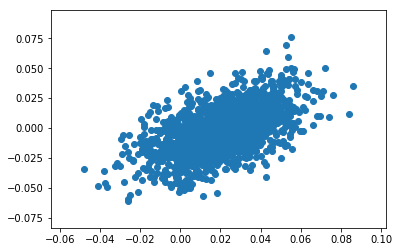

In [16]:
# Scatter the 2 dimensions of the reduced V
plt.scatter(V_PCA[:,0],V_PCA[:,1])
plt.show()

In [17]:
# Save factorization data
out = [U,V,err]
np.save('MatrixFactor_UV_err',out)